## Google Analytics 4 (GA4) Data in Pyton Using run_report

In [1]:
import os
import itertools
import numpy as np
import pandas as pd

In [2]:
from google.analytics.data_v1beta import BetaAnalyticsDataClient
from google.analytics.data_v1beta.types import DateRange
from google.analytics.data_v1beta.types import Dimension
from google.analytics.data_v1beta.types import Metric
from google.analytics.data_v1beta.types import RunReportRequest 
from google.analytics.data_v1beta.types import OrderBy 

In [3]:
property_id = "386101877"
start_date = "5daysago"
end_date = "yesterday"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'google-analytics-viso-service-account.json'
client = BetaAnalyticsDataClient()

In [4]:
# def query_data(api_response):
#     dimension_headers = [header.name for header in api_response.dimension_headers]
#     metric_headers = [header.name for header in api_response.metric_headers]
#     dimensions = []
#     metrics = []
    
#     for i in range (len(dimension_headers)):
#         dimensions.append([row.dimension_values[i].value for row in api_response.rows])
#         dimensions
    
#     for i in range(len(metric_headers)):
#         metrics.append([row.metric_values[i].value for row in api_response.rows])
#         headers = dimension_headers, metric_headers
        
#     headers = list(itertools.chain.from_iterable(headers))
#     data = dimensions, metrics
#     data = list(itertools.chain.from_iterable(data))
#     df = pd.DataFrame(data)
#     df = df.transpose()
#     df.columns = headers
#     return df

In [ ]:
#  Format Report - run_report method
def format_report(request):
    response = client.run_report(request)
    
    #  Row index
    row_index_names = [header.name for header in response.dimension_headers]
    row_header = []
    
    for i in range(len(row_index_names)):
        row_header.append([row.dimension_values[i].value for row in response.rows])
    
    row_index_names = pd.MultiIndex.from_arrays(np.array(row_header), names = np.array(row_index_names))
    
    # Row flat data
    metric_names = [header.name for header in response.metric_headers]
    data_values = []
    
    for i in range(len(metric_names)):
        data_values.append([row.metric_values[i].value for row in response.rows])
    
    output = pd.DataFrame(data = np.transpose(np.array(data_values, dtype = 'f')),
                                                index=row_index_names, columns=metric_names)
    
    return output

In [6]:
request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="month"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="averageSessionDuration"), 
                 Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'month'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date="2025-03-10", end_date="today")],
    )

request

property: "properties/386101877"
dimensions {
  name: "month"
}
dimensions {
  name: "sessionMedium"
}
metrics {
  name: "averageSessionDuration"
}
metrics {
  name: "activeUsers"
}
date_ranges {
  start_date: "2025-03-10"
  end_date: "today"
}
order_bys {
  dimension {
    dimension_name: "month"
  }
}
order_bys {
  dimension {
    dimension_name: "sessionMedium"
  }
}

In [7]:
format_report(request)

averageSessionDuration  activeUsers
month sessionMedium                                     
03    (none)                     404.016266        214.0
      (not set)                  366.223175         72.0
      email                      855.966309          2.0
      organic                    263.679077        869.0
      referral                   259.902863         20.0

In [8]:
df = format_report(request)

## Export to Excel
# df.reset_index().to_excel('GA4_python_output.xlsx', sheet_name = 'GA4_report', engine = 'xlsxwriter')

## Export to CSV
# df.to_csv('GA4_python_output.csv')

## GA4 Monthly Traffic Chart

In [9]:
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [10]:
monhtly_users_pivot = pd.pivot_table(df, 
                                     columns=['sessionMedium'], 
                                     index=['month'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
monhtly_users_pivot

sessionMedium,(none),(not set),email,organic,referral
month,,,,,
03,214,72,2,869,20


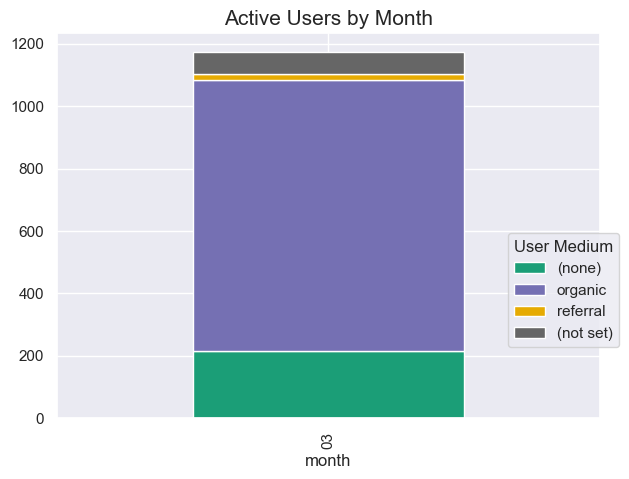

In [11]:
sns.set_theme()
monhtly_users_pivot.plot.bar(y = ['(none)', 'organic', 'referral', '(not set)'], stacked = True,
                             colormap = 'Dark2',
                             figsize=(7,5), title = 'Active Users by Month')
plt.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.5))
plt.title('Active Users by Month', fontsize = 15);

## GA4 Traffic Report

In [12]:
## Global variables
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'google-analytics-viso-service-account.json'
property_id = '386101877'
client = BetaAnalyticsDataClient()

## Report dates
end_date = 'today' ## ("today" or "yyyy-mm-dd")
no_days = 90

In [13]:
def calc_start_date(end_date, no_days):
    if end_date == "today":
        start_date = date.today() - timedelta(days=no_days)
    else:
        start_date = date.fromisoformat(end_date) - timedelta(days=no_days)
        
    return start_date.strftime("%Y-%m-%d") 

In [ ]:
def produce_report(end_date, no_days, property_id=property_id, client=client):
    daily_traffic_request = RunReportRequest(
        property='properties/'+property_id,
        dimensions=[Dimension(name="date"), 
                    Dimension(name="sessionMedium")],
        metrics=[Metric(name="activeUsers")],
        order_bys = [OrderBy(dimension = {'dimension_name': 'date'}),
                    OrderBy(dimension = {'dimension_name': 'sessionMedium'})],
        date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
    )

    page_users_request = RunReportRequest(
                property='properties/'+property_id,
                dimensions=[Dimension(name="pagePath")],
                metrics=[Metric(name="activeUsers")],
                order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
                date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
    )
        
    landing_page_users_request = RunReportRequest(
                property='properties/'+property_id,
                dimensions=[Dimension(name="landingPage")],
                metrics=[Metric(name="activeUsers")],
                order_bys = [OrderBy(metric = {'metric_name': 'activeUsers'}, desc = True)],
                date_ranges=[DateRange(start_date=calc_start_date(end_date, no_days), end_date=end_date)],
    )

    daily_traffic = format_report(daily_traffic_request).reset_index()
    active_users_pivot = pd.pivot_table(daily_traffic, 
                                     columns=['sessionMedium'], 
                                     index=['date'], 
                                     values=['activeUsers'], 
                                     aggfunc = 'sum',
                                     fill_value=0).droplevel(0, axis=1)
    active_users_pivot.index = active_users_pivot.index.str.slice(start=4)
    
    # Produce pie and line charts
    fig, (axs1, axs2) = plt.subplots(1,2, figsize = (14, 4), gridspec_kw={'width_ratios': [1, 2]})
    pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)

    pie_data.plot.pie(ax = axs1,
                      colormap = 'Dark2',
                      y = 'activeUsers',
                      title = 'Active Users by Medium',
                      legend = False, 
                      label = False,
                      startangle = 0, 
                      autopct = lambda p:f'{p:.0f}%').set_ylabel('')
    
    active_users_pivot.plot.line(ax = axs2, 
                                 colormap = 'Dark2',
                                 y = pie_data.index, 
                                 title = 'Active Users by Day')


    axs2.legend(title = 'User Medium', bbox_to_anchor = (1.05, 0.6))

    plt.show();
    
    # Produce Top 10 pages output tables
    landing_table = format_report(landing_page_users_request)
    landing_table['activeUsers'] = landing_table['activeUsers'].astype('int') 
    page_users_table = format_report(page_users_request)
    page_users_table['activeUsers'] = page_users_table['activeUsers'].astype('int') 
    
    print('\nTop 10 Landing Pages')
    display(landing_table[0:10])
    
    print('\nTop 10 Visited Pages')
    display(page_users_table[0:10])

/var/folders/5f/_dz68cmx0t7fh8678dk83hzr0000gp/T/ipykernel_31240/1079970247.py:39: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pie_data = daily_traffic.groupby(by = ['sessionMedium']).sum().sort_values(by = ['activeUsers'], ascending = False)


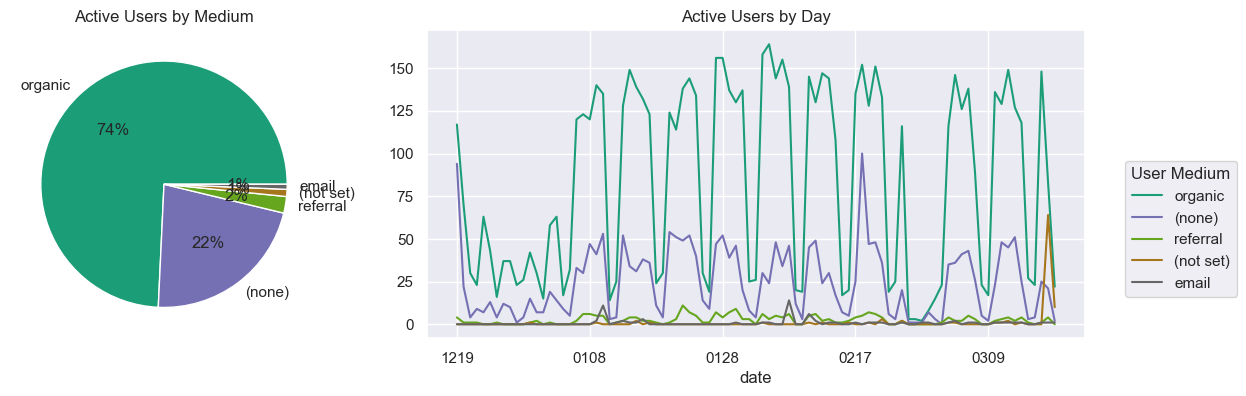


Top 10 Landing Pages


,activeUsers
landingPage,
/fr,2803
(not set),1115
/fr/2-tous-nos-produits,436
/en,374
/fr/recherche,151
/fr/content/10-catalogues,117
/fr/831-arceau-de-parking-haute-resistance-viso.html,79
/fr/43-stockage-et-manutention,71
/fr/79-boites-et-mallettes,71



Top 10 Visited Pages


,activeUsers
pagePath,
/fr/,3055
/fr/recherche,1733
/fr/content/10-catalogues,1073
/fr/2-tous-nos-produits,506
/en/,466
/fr/nous-contacter,328
/fr/133-voirie-et-parking,281
/fr/43-stockage-et-manutention,225
/en/content/10-catalogs,182


In [91]:
produce_report(end_date, no_days)